In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import scanpy as sc
import scipy as sp

import sys 
import os
sys.path.append(os.path.abspath("./utility_functions"))

import rz_functions as rz
import ng_functions as ng
import rz_utility_spring as srz

from time import time
from scipy import stats
import seaborn as sns
sns.set_style("whitegrid")


import scrublet as scr

import tox_annotation as tox


/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


python version: 3.6.10


In [2]:
adata = sc.read_h5ad('backups/tox_marie_all_cells_unnormalized_pca_umap_leiden_35358x22631_backup_200604_01h08.h5ad') #coarse + fine + scrublet

adata[:,['Il12b']].X = adata[:,['Il12b', 'eYFP']].X.sum(1)
adata[:,['eYFP']].X = 0


sc.pp.normalize_total(adata, target_sum=1e4)

adata.obs['n_counts'] = adata.X.sum(1).A1

adata.obs['mouse'] = adata.obs.library_name.map(tox.mouse_library_dict)
adata.obs.head()


,barcode,group,library_name,marker,max_mt,min_tot,mito_frac,n_counts,n_genes,pool,tissue,treatment,leiden,leiden2,doublet_score,predicted_doublet,mouse
48-pool1,AAACAAACAGAGGATAAGACACCA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.040964,9999.998047,348,pool1,Liver,NT,8,7,0.007103,False,NT1
98-pool1,AAACAAACAGAGGATACAATACTT,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.005613,10000.000000,581,pool1,Liver,NT,20,32,0.014590,False,NT1
237-pool1,AAACAAACAGAGGATAGGCCCTTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035451,9999.998047,470,pool1,Liver,NT,11,14,0.016036,False,NT1
246-pool1,AAACAAACAGAGGATAGGGAGGTA,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.018000,10000.000000,374,pool1,Liver,NT,Mono12,24,0.027342,False,NT1
342-pool1,AAACAAACAGAGGATATGGCTACC,B,Liver_CD45pos_NT_B,CD45pos,0.15,200,0.035088,10000.000000,318,pool1,Liver,NT,T17,17,0.007778,False,NT1


In [3]:
#loglikelihoods = sp.sparse.load_npz('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz')
logls = np.load('backups/loglikelihoods_bay_classif_tox_marie_all_cells_200407_11h02.npz', allow_pickle=True)

mostlikely_subset = pd.DataFrame(logls['data'], index=logls['index'], columns=logls['columns']).idxmax()
mostlikely_subset = pd.Series(mostlikely_subset, dtype='category')
mostlikely_subset.index = adata.obs.index

mostlikely_celltype = mostlikely_subset.map(ng.cell_subset_dict).astype('category')

In [4]:
adata.obs['cell_type'] = mostlikely_celltype
adata.obs['minor_subset'] = mostlikely_subset

#annotate color palette in adata.uns
adata.uns['cell_type_colors'] = adata.obs['cell_type'].cat.categories.map(ng.cell_type_cmap).tolist()
adata.uns['minor_subset_colors'] = adata.obs['minor_subset'].cat.categories.map(ng.cell_subset_cmap).tolist()

In [5]:
adata = adata[~(adata.obs.predicted_doublet)]
adata = adata[~adata.obs['leiden'].isin(['16', '28','29','30'])]

adata.obs['leiden_minor_subset'] = adata.obs.leiden.map(tox.cluster_annotation_dict).astype('category')
adata.obs['leiden_cell_type'] = adata.obs.leiden_minor_subset.map(tox.coarse_annotation_dict).astype('category')


Trying to set attribute `.obs` of view, copying.


## Reference sets of libraries and clusters

In [6]:
il12b_types = ['DC_CCR7+_CXCL9-', 'DC_CD83_lo', 'DC_Trx2', 'DC_Trx1', 'DC_S100A9+', 'KClike_MARCO-', 'KClike_MARCO+']
il12b_dc = ['DC_CCR7+_CXCL9-', 'DC_CD83_lo', 'DC_Trx2', 'DC_Trx1', 'DC_S100A9+']
il12b_kc = ['KClike_MARCO-', 'KClike_MARCO+']

liver_il12b_trx_libraries = ['Liver_IL12_Trx_I_rep1', 'Liver_IL12_Trx_I_rep2', 'Liver_IL12_Trx_J_rep1', 'Liver_IL12_Trx_J_rep2']

In [7]:
def multiindex_pivot(df, columns=None, values=None):
    #https://github.com/pandas-dev/pandas/issues/23955
    names = list(df.index.names)
    df = df.reset_index()
    list_index = df[names].values
    tuples_index = [tuple(i) for i in list_index] # hashable
    df = df.assign(tuples_index=tuples_index)
    df = df.pivot(index="tuples_index", columns=columns, values=values)
    tuples_index = df.index  # reduced
    index = pd.MultiIndex.from_tuples(tuples_index, names=names)
    df.index = index
    return df

In [216]:
regex_toavoid = r'(mt-.*|Rps.*|Rpl.*|Mrpl.*|Mrps.*)'

# Dendritic clusters

## Filter for IL12b+ treated DCs from the IL12b+ liver treated libraries // Add log values for gene variability analysis downstream

In [8]:
il12dcdata = adata[adata.obs.leiden_minor_subset.isin(il12b_dc) & adata.obs.library_name.isin(liver_il12b_trx_libraries)]
sc.pp.log1p(il12dcdata)

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Split data by mouse (Trx1 / Trx3)

In [73]:
il12dcdata1 = il12dcdata[il12dcdata.obs.mouse == 'Trx1']
il12dcdata3 = il12dcdata[il12dcdata.obs.mouse == 'Trx3']

In [151]:
il12dcdata1_X = np.array(il12dcdata1.X.todense())
il12dcdata3_X = np.array(il12dcdata3.X.todense())

fanosort_dc1 = np.argsort(np.var(il12dcdata1_X, axis=0)/np.mean(il12dcdata1_X, axis=0))
fanosort_dc3 = np.argsort(np.var(il12dcdata3_X, axis=0)/np.mean(il12dcdata3_X, axis=0))

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [205]:
hvdc_trx1 = il12dcdata1.var_names[fanosort_dc1]
hvdc_trx1 = hvdc_trx1[~hvdc_trx1.str.match(regex_toavoid)]

hvdc_trx3 = il12dcdata3.var_names[fanosort_dc3]
hvdc_trx3 = hvdc_trx3[~hvdc_trx3.str.match(regex_toavoid)]


#genes_toavoid_dc1 = il12dcdata1.var_names[fanosort_dc1].str.match(regex_toavoid)

In [199]:
#hvdc_trx1 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata1, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False)
#hvdc_trx3 = pd.DataFrame(sc.pp.highly_variable_genes(il12dcdata3, n_top_genes=50, inplace=False)).merge(pd.Series(il12dcdata3.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False)

In [202]:
len_genes_in_common = []
for i in range(500):
    tmp_trx1 = hvdc_trx1[:i]
    tmp_trx3 = hvdc_trx1[:i]
    
    in_common = set(hvdc_trx1[:i]) & set(hvdc_trx3[:i])
    
    len_genes_in_common.append(len(in_common))
    

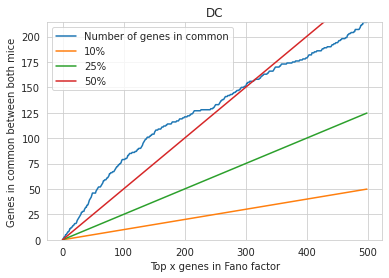

In [204]:

plt.plot(len_genes_in_common, label='Number of genes in common')
plt.plot(0.10*np.arange(0,500,1), label='10%')
plt.plot(0.25*np.arange(0,500,1), label='25%')
plt.plot(0.50*np.arange(0,500,1), label='50%')

plt.ylim(0,len_genes_in_common[-1])
plt.ylabel('Genes in common between both mice')
plt.xlabel('Top x genes in Fano factor')
plt.title('DC')

plt.legend()

## Compute the 25 most variable genes that are highly variable in both mice

In [209]:
hvdc_genes_consensus = set(hvdc_trx1[:30]) & set(hvdc_trx3[:30])

In [210]:
len(hvdc_genes_consensus)

25

In [211]:
hvdcdata = il12dcdata[:,il12dcdata.var_names.isin(hvdc_genes_consensus)]
hvdcx = pd.DataFrame(hvdcdata.X.todense(), columns=hvdcdata.var.index, index=hvdcdata.obs.index)
hvdcdf = hvdcdata.obs.loc[:,['mouse']].merge(hvdcx, left_index=True, right_index=True)#.groupby(['rep', 'leiden_minor_subset']).cov()

In [212]:
hvdcstd = hvdcdf.groupby(['mouse']).std().T

hvdccov = hvdcdf.groupby(['mouse']).cov()
hvdccov = hvdccov.reset_index().melt(id_vars=['mouse', 'level_1'])

hvdccorr = hvdcdf.groupby(['mouse']).corr()
hvdccorr = hvdccorr.reset_index().melt(id_vars=['mouse', 'level_1'])

In [264]:
hvdccov_scatter = multiindex_pivot(hvdccov.set_index(['variable','level_1']), columns='mouse', values='value') 
hvdccov_scatter = hvdccov_scatter.rename(columns=str).reset_index()

hvdccorr_scatter = multiindex_pivot(hvdccorr.set_index(['variable','level_1']), columns='mouse', values='value') 
hvdccorr_scatter = hvdccorr_scatter.rename(columns=str).reset_index()

hvdccorr_scatter = hvdccorr_scatter[hvdccorr_scatter.variable != hvdccorr_scatter.level_1]

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


[<Figure size 600x400 with 1 Axes>, <Figure size 600x400 with 1 Axes>]

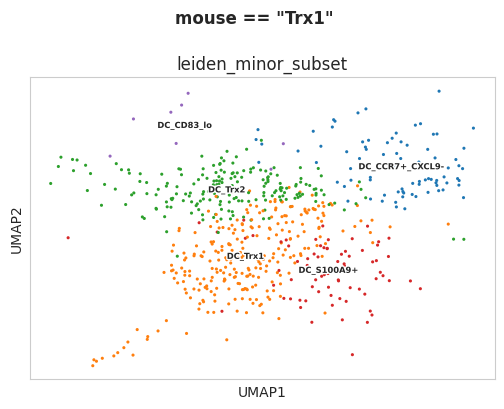

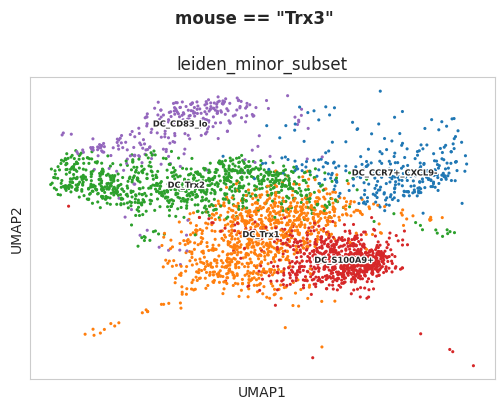

In [214]:
ng.umap_plot(il12dcdata, split_by_cats = 'mouse', color = 'leiden_minor_subset', size=20)

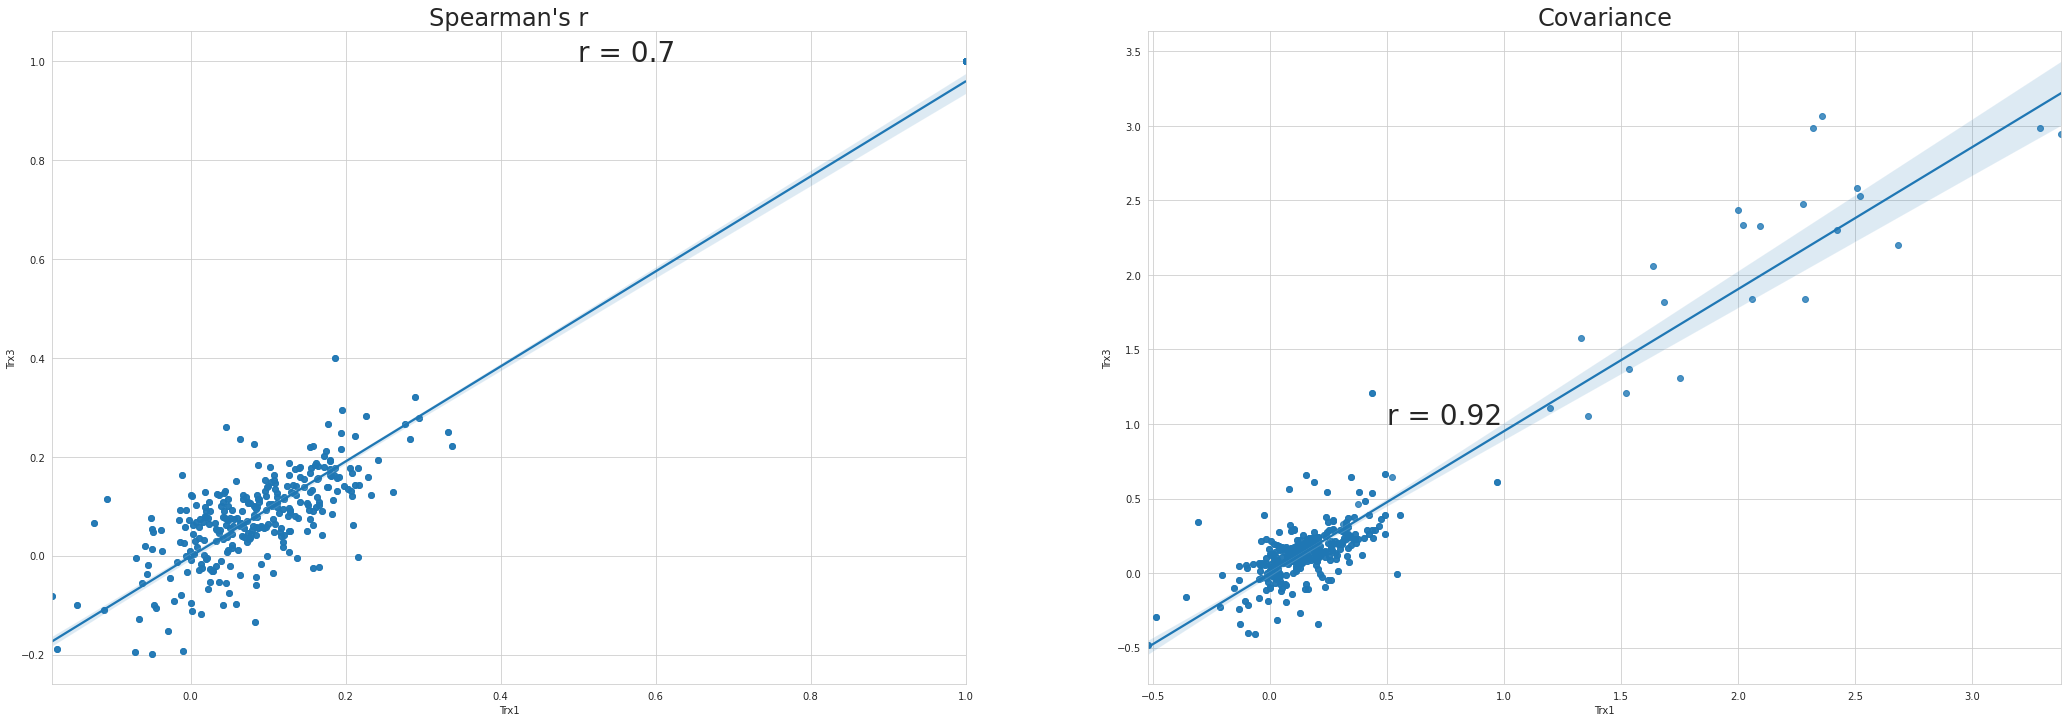

In [215]:
fig, axes = plt.subplots(1,2, figsize=(36,12))

#std_correl = round(hvdcstd.corr().iloc[0,1],2)
corr_correl = round(hvdccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvdccov_scatter.corr().iloc[0,1],2)

# std_plot = sns.regplot(data=hvdcstd, x='Trx1', y='Trx3', ax=axes[0], robust=False)
# std_plot.annotate('r = {}'.format(std_correl), (0.5,1), fontsize=28)
# axes[0].set_title('Standard deviation', fontsize=24)

corr_plot = sns.regplot(data=hvdccorr_scatter, x='Trx1', y='Trx3', ax=axes[0], robust=False)
corr_plot.annotate('r = {}'.format(corr_correl), (0.5,1), fontsize=28)
axes[0].set_title("Spearman's r", fontsize=24)

cov_plot = sns.regplot(data=hvdccov_scatter, x='Trx1', y='Trx3', ax=axes[1], robust=False)
cov_plot.annotate('r = {}'.format(cov_correl), (0.5,1), fontsize=28)
axes[1].set_title("Covariance", fontsize= 24)


plt.show()

# KC-like clusters

## Filter for IL12b+ treated KCs from the IL12b+ liver treated libraries // Add log values for gene variability analysis downstream

In [217]:
il12kcdata = adata[adata.obs.leiden_minor_subset.isin(il12b_kc) & adata.obs.library_name.isin(liver_il12b_trx_libraries)]
il12kcdata.obs.mouse = il12kcdata.obs.mouse.astype('category')
sc.pp.log1p(il12kcdata)

Trying to set attribute `.obs` of view, copying.


## Split data by mouse (Trx1 / Trx3)

In [218]:
il12kcdata1 = il12kcdata[il12kcdata.obs.mouse == 'Trx1']
il12kcdata3 = il12kcdata[il12kcdata.obs.mouse == 'Trx3']

In [219]:
il12kcdata1_X = np.array(il12kcdata1.X.todense())
il12kcdata3_X = np.array(il12kcdata3.X.todense())

fanosort_kc1 = np.argsort(np.var(il12kcdata1_X, axis=0)/np.mean(il12kcdata1_X, axis=0))
fanosort_kc3 = np.argsort(np.var(il12kcdata3_X, axis=0)/np.mean(il12kcdata3_X, axis=0))

/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/ng136/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [220]:
hvkc_trx1 = il12kcdata1.var_names[fanosort_kc1]
hvkc_trx1 = hvkc_trx1[~hvkc_trx1.str.match(regex_toavoid)]

hvkc_trx3 = il12kcdata3.var_names[fanosort_kc3]
hvkc_trx3 = hvkc_trx3[~hvkc_trx3.str.match(regex_toavoid)]


#genes_toavoid_kc1 = il12kcdata1.var_names[fanosort_kc1].str.match(regex_toavoid)

In [221]:
# hvkc_trx1 = pd.DataFrame(sc.pp.highly_variable_genes(il12kcdata1, n_top_genes=50, inplace=False)).merge(pd.Series(il12kcdata1.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False)
# hvkc_trx3 = pd.DataFrame(sc.pp.highly_variable_genes(il12kcdata3, n_top_genes=50, inplace=False)).merge(pd.Series(il12kcdata3.var_names).rename('gene_name'), left_index=True, right_index=True).sort_values('dispersions_norm', ascending = False)

In [223]:
len_genes_in_common = []
for i in range(500):
    tmp_trx1 = hvkc_trx1[:i]
    tmp_trx3 = hvkc_trx1[:i]
    
    in_common = set(hvkc_trx1[:i]) & set(hvkc_trx3[:i])
    
    len_genes_in_common.append(len(in_common))
    

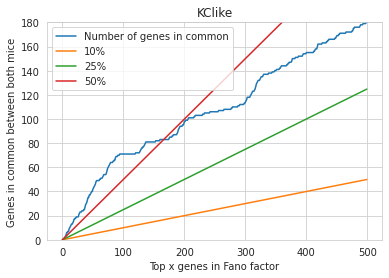

In [257]:

plt.plot(len_genes_in_common, label='Number of genes in common')
plt.plot(0.10*np.arange(0,500,1), label='10%')
plt.plot(0.25*np.arange(0,500,1), label='25%')
plt.plot(0.50*np.arange(0,500,1), label='50%')

plt.ylim(0,len_genes_in_common[-1])
plt.ylabel('Genes in common between both mice')
plt.xlabel('Top x genes in Fano factor')

plt.title('KClike')

plt.legend()

## Compute the 25 most variable genes that are highly variable in both mice

In [237]:
hvkc_genes_consensus = set(hvkc_trx1[:35]) & set(hvkc_trx3[:35])

In [238]:
print(len(hvkc_genes_consensus))

25


In [239]:
hvkcdata = il12kcdata[:,il12kcdata.var_names.isin(hvkc_genes_consensus)]
hvkcx = pd.DataFrame(hvkcdata.X.todense(), columns=hvkcdata.var.index, index=hvkcdata.obs.index)
hvkcdf = hvkcdata.obs.loc[:,['mouse']].merge(hvkcx, left_index=True, right_index=True)#.groupby(['rep', 'leiden_minor_subset']).cov()

In [240]:
hvkcstd = hvkcdf.groupby(['mouse']).std().T

hvkccov = hvkcdf.groupby(['mouse']).cov()
hvkccov = hvkccov.reset_index().melt(id_vars=['mouse', 'level_1'])

hvkccorr = hvkcdf.groupby(['mouse']).corr()
hvkccorr = hvkccorr.reset_index().melt(id_vars=['mouse', 'level_1'])

In [263]:
hvkccov_scatter = multiindex_pivot(hvkccov.set_index(['variable','level_1']), columns='mouse', values='value') 
hvkccov_scatter = hvkccov_scatter.rename(columns=str).reset_index()

hvkccorr_scatter = multiindex_pivot(hvkccorr.set_index(['variable','level_1']), columns='mouse', values='value') 
hvkccorr_scatter = hvkccorr_scatter.rename(columns=str).reset_index()

hvkccorr_scatter = hvkccorr_scatter[hvkccorr_scatter.variable != hvkccorr_scatter.level_1]

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


[<Figure size 600x400 with 1 Axes>, <Figure size 600x400 with 1 Axes>]

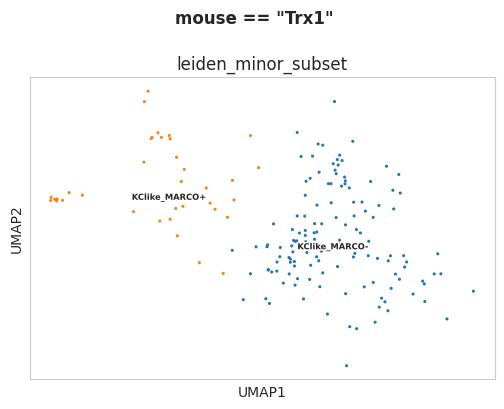

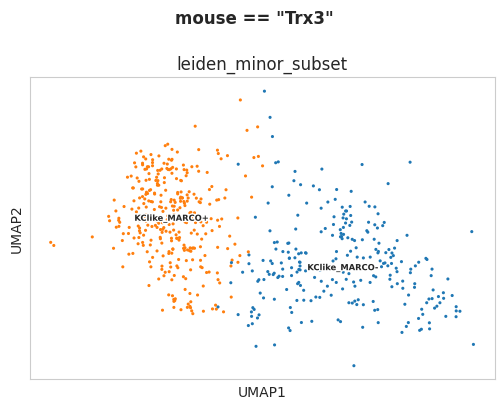

In [242]:
ng.umap_plot(il12kcdata, split_by_cats = 'mouse', color = 'leiden_minor_subset', size=20)

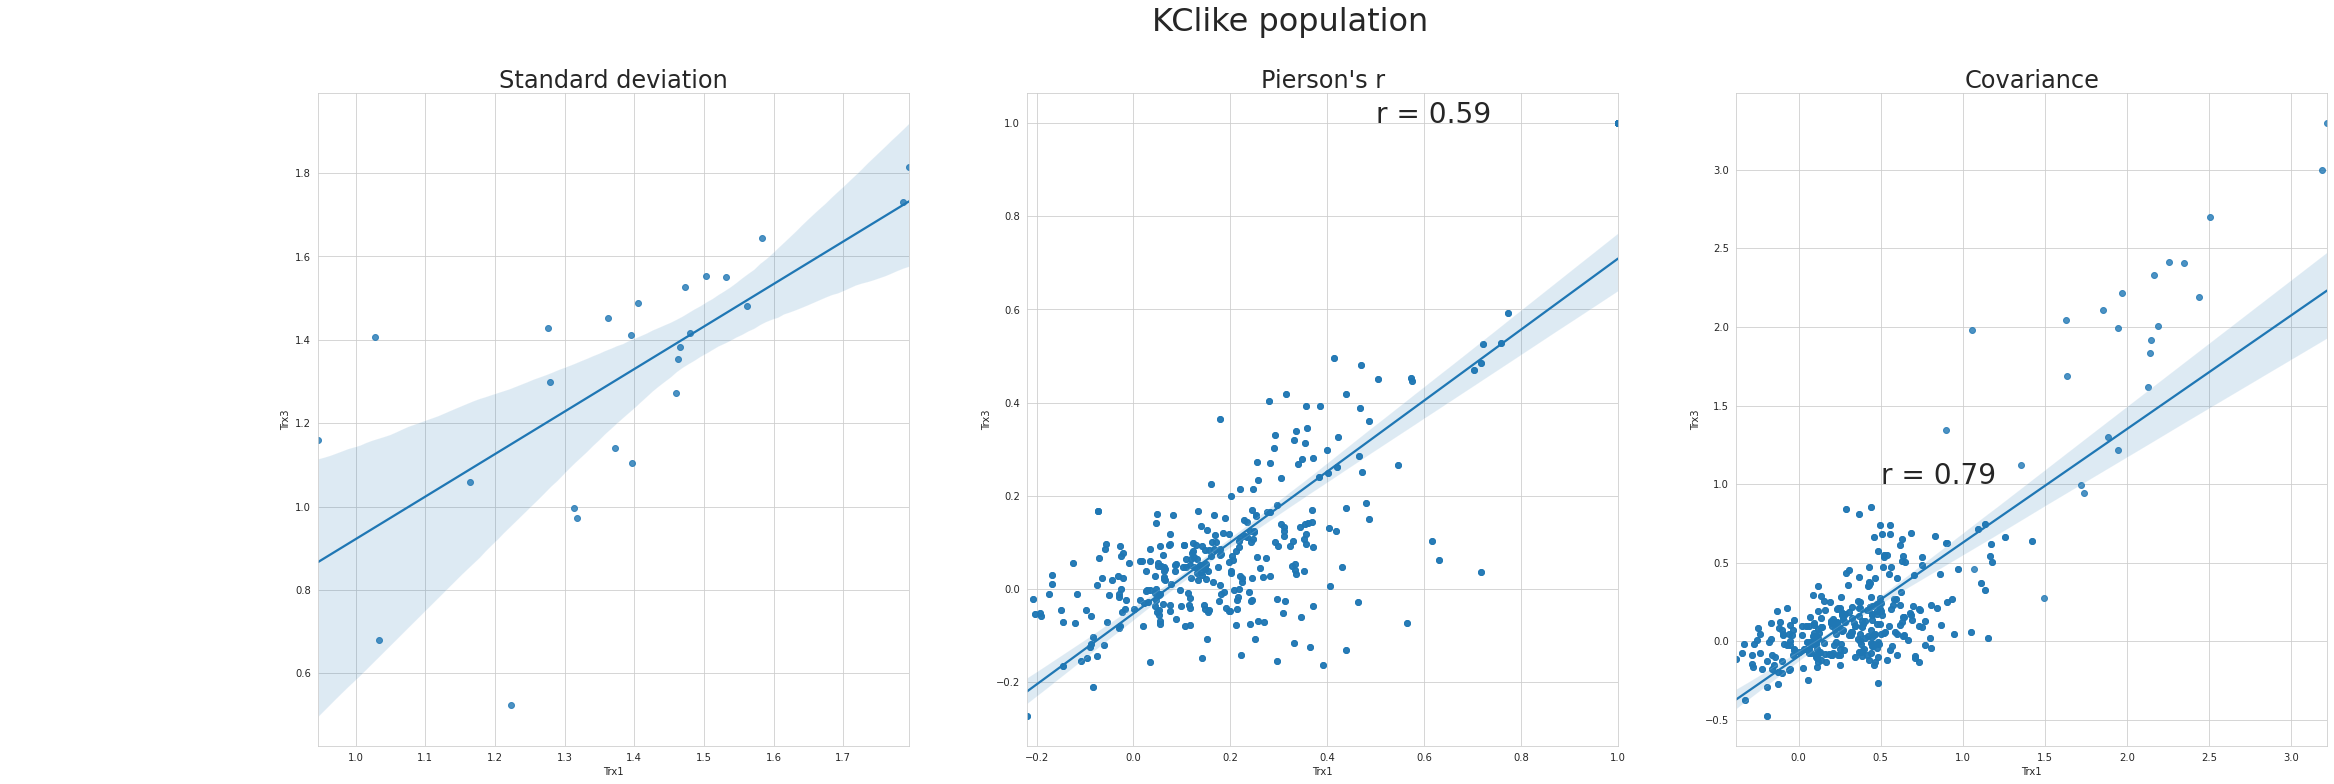

In [245]:
fig, axes = plt.subplots(1,3, figsize=(36,12))

#std_correl = round(hvkcstd.corr().iloc[0,1],2)
corr_correl = round(hvkccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvkccov_scatter.corr().iloc[0,1],2)

std_plot = sns.regplot(data=hvkcstd, x='Trx1', y='Trx3', ax=axes[0], robust=False)
std_plot.annotate('r = {}'.format(std_correl), (0.5,1), fontsize=28)
axes[0].set_title('Standard deviation', fontsize=24)

corr_plot = sns.regplot(data=hvkccorr_scatter, x='Trx1', y='Trx3', ax=axes[1], robust=False)
corr_plot.annotate('r = {}'.format(corr_correl), (0.5,1), fontsize=28)
axes[1].set_title("Pierson's r", fontsize=24)

cov_plot = sns.regplot(data=hvkccov_scatter, x='Trx1', y='Trx3', ax=axes[2], robust=False)
cov_plot.annotate('r = {}'.format(cov_correl), (0.5,1), fontsize=28)
axes[2].set_title("Covariance", fontsize= 24)

plt.suptitle('KClike population', fontsize=32)

plt.show()

In [246]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

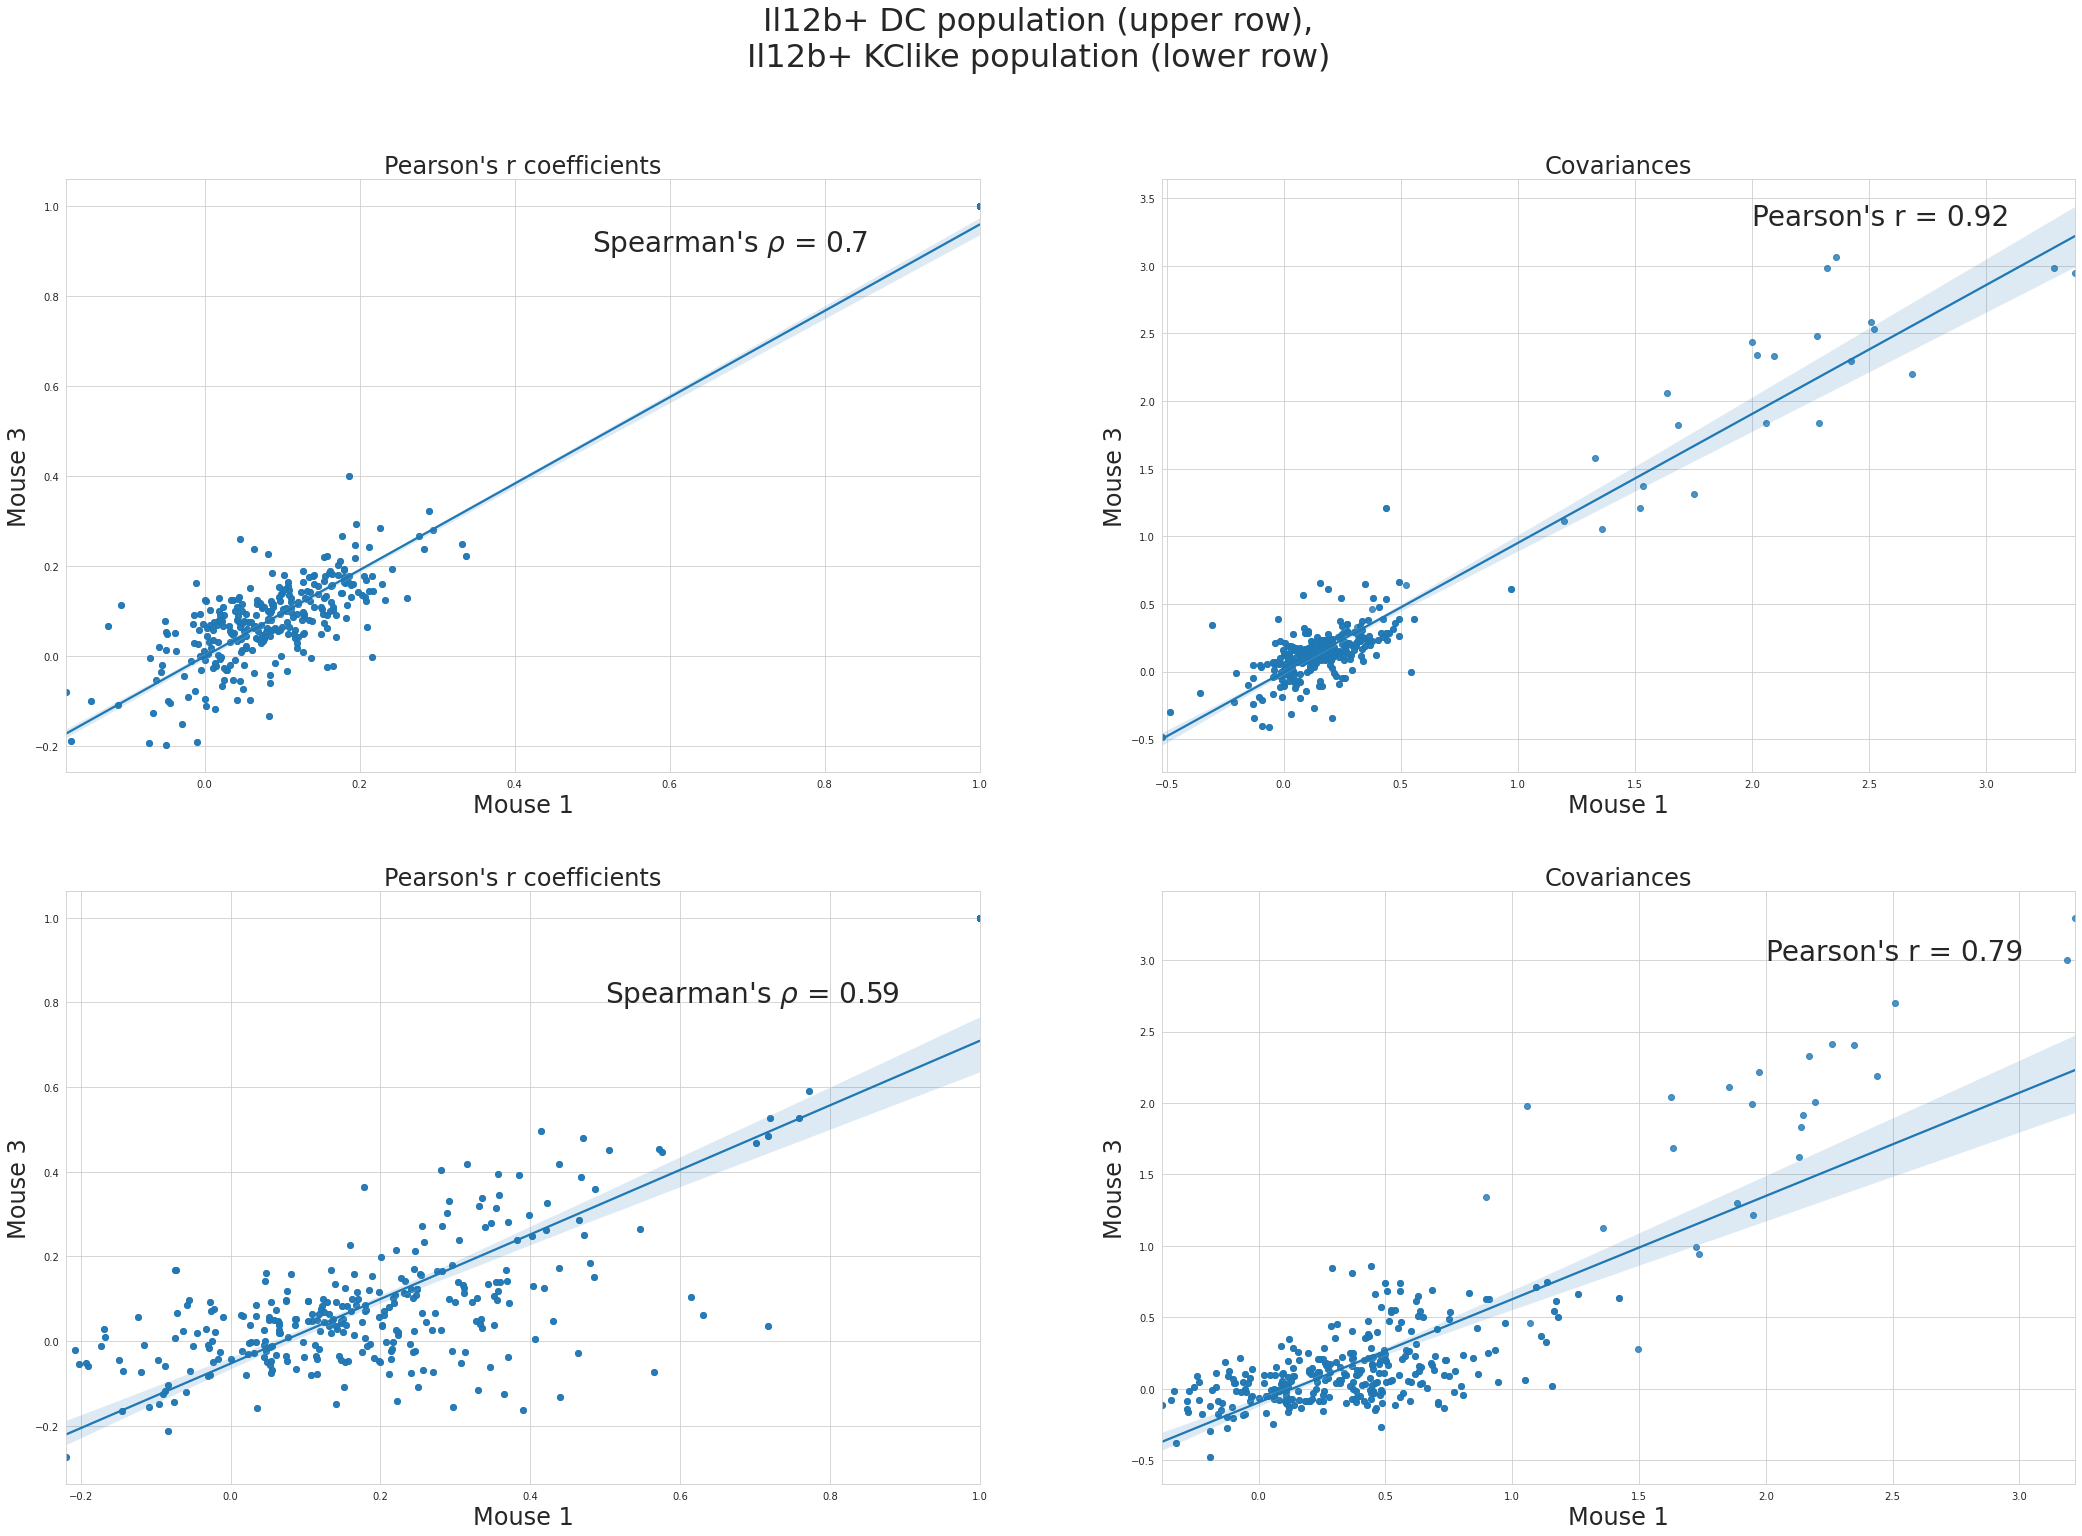

In [256]:
fig, axes = plt.subplots(2,2, figsize=(36,24))

corr_correl = round(hvdccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvdccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvdccorr_scatter, x='Trx1', y='Trx3', ax=axes[0,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.5,0.9), fontsize=28)
axes[0,0].set_title("Pearson's r coefficients", fontsize=24)

cov_plot = sns.regplot(data=hvdccov_scatter, x='Trx1', y='Trx3', ax=axes[0,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (2.0,3.3), fontsize=28)
axes[0,1].set_title("Covariances", fontsize= 24)

corr_correl = round(hvkccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvkccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvkccorr_scatter, x='Trx1', y='Trx3', ax=axes[1,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.5,0.8), fontsize=28)
axes[1,0].set_title("Pearson's r coefficients", fontsize=24)

cov_plot = sns.regplot(data=hvkccov_scatter, x='Trx1', y='Trx3', ax=axes[1,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (2.0,3.0), fontsize=28)
axes[1,1].set_title("Covariances", fontsize= 24)

plt.suptitle('Il12b+ DC population (upper row),\nIl12b+ KClike population (lower row)', fontsize=32)

for ax in axes.ravel():
    ax.set_xlabel('Mouse 1', fontsize=24)
    ax.set_ylabel('Mouse 3', fontsize=24)

plt.show()

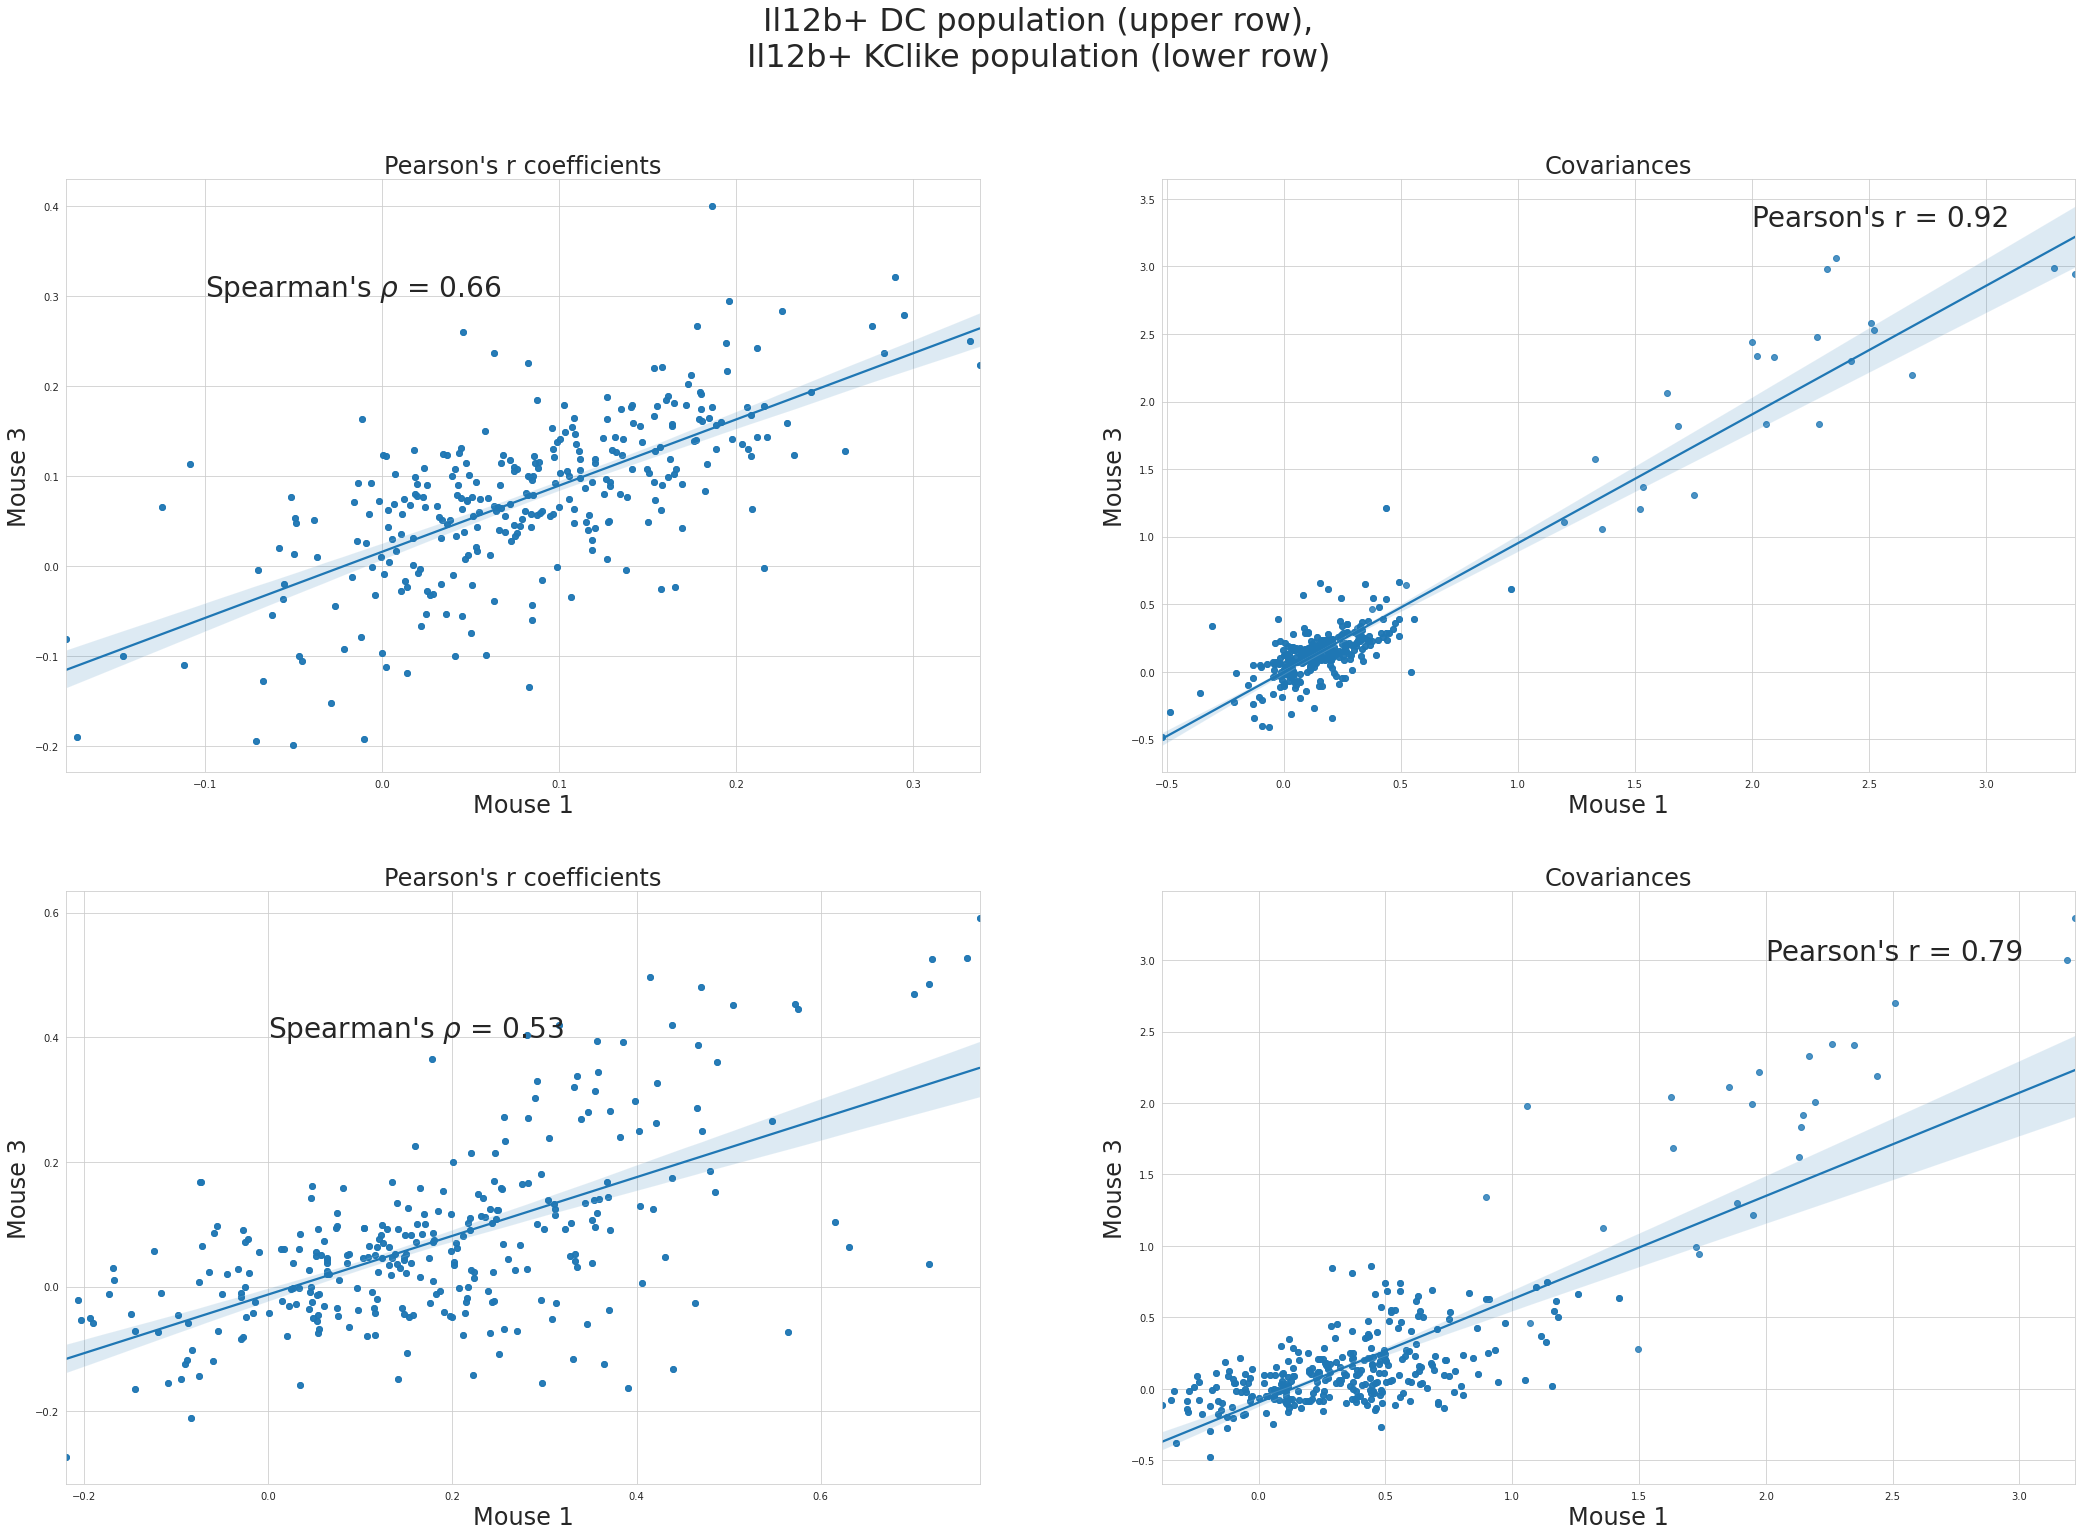

In [270]:
fig, axes = plt.subplots(2,2, figsize=(36,24))

corr_correl = round(hvdccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvdccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvdccorr_scatter, x='Trx1', y='Trx3', ax=axes[0,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (-0.1,0.3), fontsize=28)
axes[0,0].set_title("Pearson's r coefficients", fontsize=24)

cov_plot = sns.regplot(data=hvdccov_scatter, x='Trx1', y='Trx3', ax=axes[0,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (2.0,3.3), fontsize=28)
axes[0,1].set_title("Covariances", fontsize= 24)

corr_correl = round(hvkccorr_scatter.corr(method='spearman').iloc[0,1],2)
cov_correl = round(hvkccov_scatter.corr().iloc[0,1],2)

corr_plot = sns.regplot(data=hvkccorr_scatter, x='Trx1', y='Trx3', ax=axes[1,0], robust=False)
corr_plot.annotate(r"Spearman's $\rho$ = {}".format(corr_correl), (0.0,0.4), fontsize=28)
axes[1,0].set_title("Pearson's r coefficients", fontsize=24)

cov_plot = sns.regplot(data=hvkccov_scatter, x='Trx1', y='Trx3', ax=axes[1,1], robust=False)
cov_plot.annotate(r"Pearson's r = {}".format(cov_correl), (2.0,3.0), fontsize=28)
axes[1,1].set_title("Covariances", fontsize= 24)

plt.suptitle('Il12b+ DC population (upper row),\nIl12b+ KClike population (lower row)', fontsize=32)

for ax in axes.ravel():
    ax.set_xlabel('Mouse 1', fontsize=24)
    ax.set_ylabel('Mouse 3', fontsize=24)

plt.show()

In [267]:
corr_correl

0.53